In [1]:
import pandas as pd
from pmdarima.arima import auto_arima

#85 percent train 15 percent test

In [2]:
df = pd.read_csv('variable_selected_county_dataset.csv', index_col=0)

In [3]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tools.sm_exceptions import ValueWarning
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA


warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller

data = pd.read_csv('variable_selected_county_dataset.csv').iloc[:, 1:]


def difference(df):
    df['incremental_cases'] = df['incremental_cases'].diff().fillna(df['incremental_cases'])
    return df


nyc = data[data['entity'] == 'New York-Nassau'].loc[:, ['date', 'incremental_cases']]
nyc['incremental_cases'] = nyc['incremental_cases'].astype('int')
nyc['date'] = pd.to_datetime(nyc['date'], format="%Y-%m-%d")

# use 85%-15% for train-test split
train = nyc.iloc[:230, :]
test = nyc.iloc[230:, :]

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

# NYC data is stationary without any differencing
stationary_test(train.incremental_cases)

(-3.56310214760178, 0.00650690429463449)

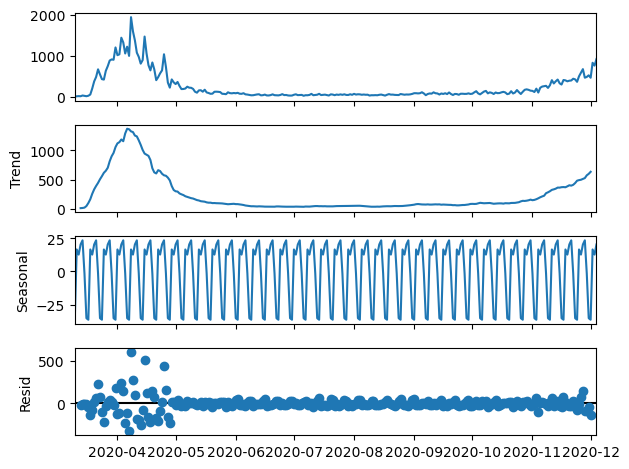

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

analysis = nyc.set_index('date').copy()


decompose_result_mult = seasonal_decompose(analysis)

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

In [32]:
analysis

,incremental_cases
date,
2020-03-10,2
2020-03-11,9
2020-03-12,13
2020-03-13,10
2020-03-14,28
...,...
2020-11-30,520
2020-12-01,461
2020-12-02,826


In [24]:
for x in decompose_result_mult.seasonal:
    print(x)

-36.423795976427556
16.61633814265394
12.724446250762039
20.365677707782975
23.508534850640114
-1.5102621418410929
-35.280938833570424
-36.423795976427556
16.61633814265394
12.724446250762039
20.365677707782975
23.508534850640114
-1.5102621418410929
-35.280938833570424
-36.423795976427556
16.61633814265394
12.724446250762039
20.365677707782975
23.508534850640114
-1.5102621418410929
-35.280938833570424
-36.423795976427556
16.61633814265394
12.724446250762039
20.365677707782975
23.508534850640114
-1.5102621418410929
-35.280938833570424
-36.423795976427556
16.61633814265394
12.724446250762039
20.365677707782975
23.508534850640114
-1.5102621418410929
-35.280938833570424
-36.423795976427556
16.61633814265394
12.724446250762039
20.365677707782975
23.508534850640114
-1.5102621418410929
-35.280938833570424
-36.423795976427556
16.61633814265394
12.724446250762039
20.365677707782975
23.508534850640114
-1.5102621418410929
-35.280938833570424
-36.423795976427556
16.61633814265394
12.72444625076203

In [46]:
arimaModel = nyc[['date', 'incremental_cases']]
train = arimaModel.head(int(0.85*len(arimaModel))+1)
test = arimaModel.tail(int(0.15*len(arimaModel)))

In [47]:
import statsmodels.api as sm

In [39]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')
n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

p_values = [1,2,3]
q_values = [1,2,3]

P_values = [1,2, 3]
Q_values = [1,3, 2]


best_score, best_cfg = float("inf"), None



for p in p_values:
    for q in q_values:
        for P in P_values:
            for Q in Q_values:
                order = (p, q, P, Q)
                avg = 0
                for train_index, val_index in tscv.split(train):
                    train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
                    try:
                        model=sm.tsa.statespace.SARIMAX(train['incremental_cases'],order=(p,0,q), seasonal_order=(P,0,Q,7)).fit()
                    except:
                        continue
                    forecast = model.forecast(steps=val_data.shape[0])
                    mse = mean_squared_error(val_data.incremental_cases, forecast)
                    avg += mse
                if avg < best_score:
                    if avg > 0:
                        best_score, best_cfg = avg, order

print(f'Best ARIMA parameters: {best_cfg} with MSE: {best_score}')

Best ARIMA parameters: (3, 1, 2, 1) with MSE: 3816.8573347639176


-2.2149645660885238


<Axes: title={'center': 'SARIMA Predictions for New York'}, xlabel='date'>

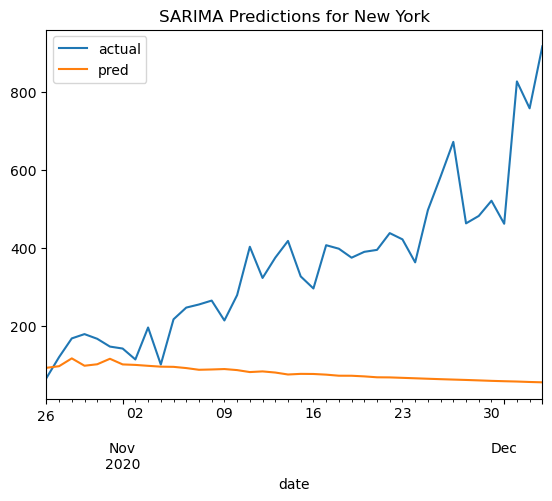

In [61]:
model =sm.tsa.statespace.SARIMAX(train['incremental_cases'],order=(3,0,1), seasonal_order=(2,0,1,7)).fit()
pred = model.forecast(steps=40)
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test.reset_index().date
prediction.plot(x = 'date', y = ['actual', 'pred'], title='SARIMA Predictions for New York')

-2.773528914177897


<Axes: title={'center': 'SARIMA Predictions for New York'}, xlabel='date'>

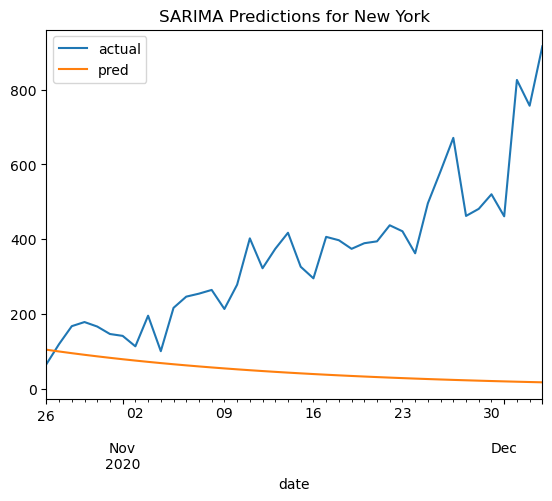

In [62]:
model =sm.tsa.statespace.SARIMAX(train['incremental_cases']).fit()
pred = model.forecast(steps=40)
r2 = r2_score(test.incremental_cases, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test.reset_index().date
prediction.plot(x = 'date', y = ['actual', 'pred'], title='SARIMA Predictions for New York')

<Axes: xlabel='date'>

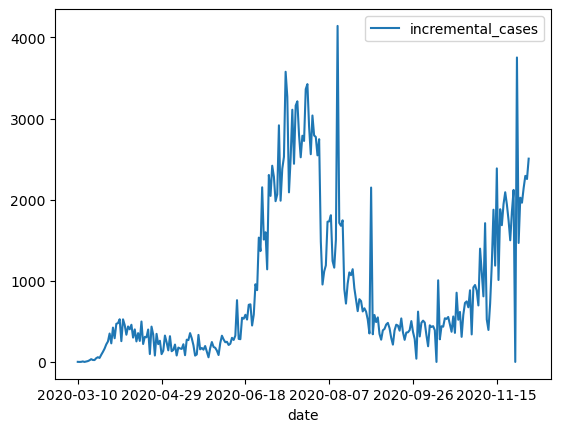

In [4]:
# get selected coutnties
miami = df[df.entity == 'Florida-Miami-Dade']
miami = miami[['date', 'incremental_cases']]
#miami.reset_index(inplace=True)
miami.plot(x='date', y='incremental_cases')


In [5]:
#need to differentiate twice to not be stationary
diffDf = miami.set_index('date')

statDF = diffDf.diff().diff()
firstVal = diffDf.diff(1).iloc[1,:].incremental_cases
firstDiff = diffDf.diff()

split = int(0.85 * len(statDF))
train = statDF.iloc[:split,:]
test = statDF.iloc[split:, :]
compareTest = diffDf.iloc[split:, :]

def fromTestDiffToActualInc(test, firstVal, secondVal):
    test.iloc[0,0] += firstVal
    test = test.cumsum()
    test.iloc[0,0] += secondVal
    return test.cumsum()

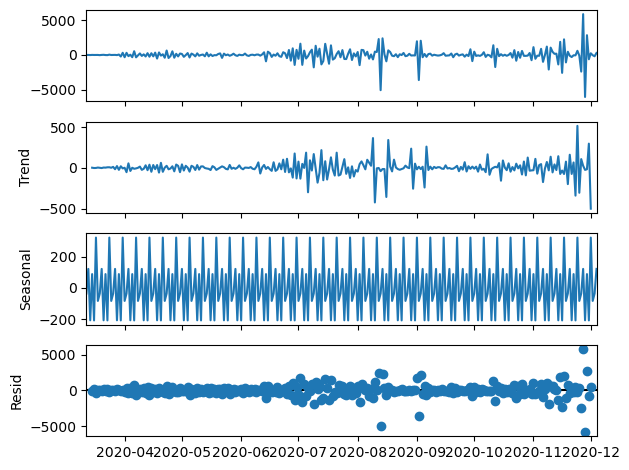

In [65]:
analysis = statDF.copy()
analysis.dropna(inplace=True)
analysis.index = pd.to_datetime(analysis.index)


decompose_result_mult = seasonal_decompose(analysis)

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

In [66]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

train = train.loc[:, ['incremental_cases']].reset_index()
n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

p_values = [1,2,3]
q_values = [1,2,3]

P_values = [1,2,3]
Q_values = [1,2,3]


best_score, best_cfg = float("inf"), None

for p in p_values:
    for q in q_values:
        for P in P_values:
            for Q in Q_values:
                order = (p, q, P, Q)
                avg = 0
                for train_index, val_index in tscv.split(train):
                    train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
                    try:
                        model=sm.tsa.statespace.SARIMAX(train['incremental_cases'],order=(p,2,q), seasonal_order=(P,2,Q,7)).fit()
                    except:
                        continue
                    forecast = model.forecast(steps=val_data.shape[0])
                    mse = mean_squared_error(val_data.incremental_cases, forecast)
                    avg += mse
                if avg < best_score:
                    if avg > 0:
                        best_score, best_cfg = avg, order



print(f'Best ARIMA parameters: {best_cfg} with MSE: {best_score}')

Best ARIMA parameters: (1, 2, 2, 3) with MSE: 1860204.2280701755


-4.66905559664103


<Axes: title={'center': 'SARIMA Predictions for Miami'}, xlabel='date'>

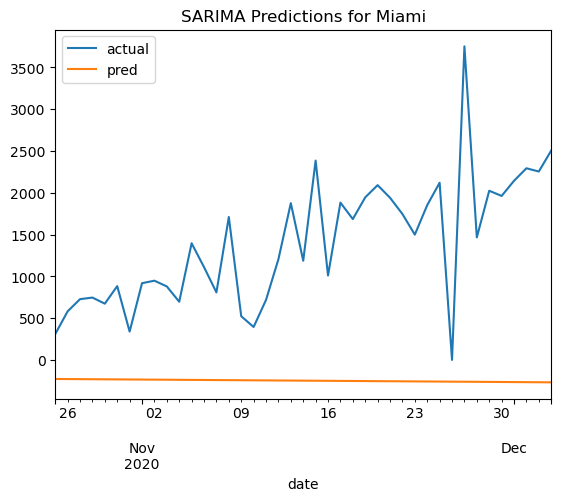

In [69]:
from sklearn.metrics import r2_score

model = sm.tsa.statespace.SARIMAX(train['incremental_cases'],order=(1,2,2), seasonal_order=(2,2,3,7)).fit()
pred = model.forecast(steps=41)


predictTest = pd.DataFrame(pred)
predictTest.columns=['incremental_cases']

foo = pd.DataFrame(model.fittedvalues, columns=['incremental_cases'])
foo.iloc[1,0] = diffDf.diff().iloc[1,0]
foo = foo.cumsum()
firstVal = foo.iloc[-1,0].copy()

foo.iloc[0,0] = diffDf.iloc[0,0]
foo = foo.cumsum()
secondVal = foo.iloc[-1,0].copy()



fooooo = predictTest.copy()
finalIncrementPreds = fromTestDiffToActualInc(fooooo, firstVal, secondVal)



r2 = r2_score(miami.iloc[split:, :].incremental_cases, finalIncrementPreds)
print(r2)

prediction = pd.DataFrame({'actual':miami.iloc[split:, :].incremental_cases.reset_index(drop = True), 
              'pred':finalIncrementPreds.incremental_cases.reset_index(drop = True)})
prediction['date'] = pd.to_datetime(test.index)
prediction.plot(x = 'date', y = ['actual', 'pred'], title='SARIMA Predictions for Miami')

-2.223647962767265


<Axes: title={'center': 'SARIMA Predictions for Miami'}, xlabel='date'>

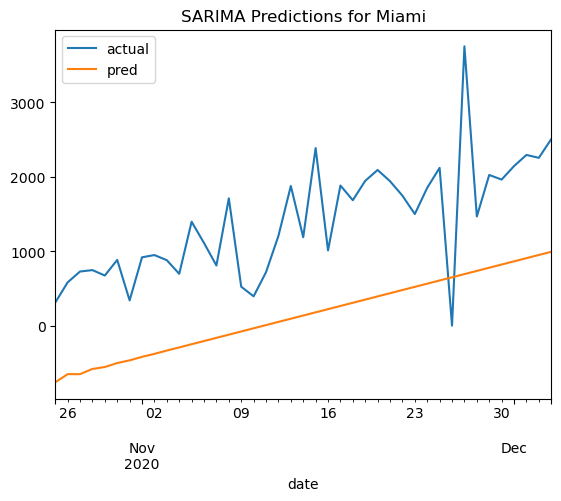

In [6]:
from sklearn.metrics import r2_score

model = sm.tsa.statespace.SARIMAX(train['incremental_cases']).fit()
pred = model.forecast(steps=41)


predictTest = pd.DataFrame(pred)
predictTest.columns=['incremental_cases']

foo = pd.DataFrame(model.fittedvalues, columns=['incremental_cases'])
foo.iloc[1,0] = diffDf.diff().iloc[1,0]
foo = foo.cumsum()
firstVal = foo.iloc[-1,0].copy()

foo.iloc[0,0] = diffDf.iloc[0,0]
foo = foo.cumsum()
secondVal = foo.iloc[-1,0].copy()



fooooo = predictTest.copy()
finalIncrementPreds = fromTestDiffToActualInc(fooooo, firstVal, secondVal)



r2 = r2_score(miami.iloc[split:, :].incremental_cases, finalIncrementPreds)
print(r2)

prediction = pd.DataFrame({'actual':miami.iloc[split:, :].incremental_cases.reset_index(drop = True), 
              'pred':finalIncrementPreds.incremental_cases.reset_index(drop = True)})
prediction['date'] = pd.to_datetime(test.index)
prediction.plot(x = 'date', y = ['actual', 'pred'], title='SARIMA Predictions for Miami')

<Axes: xlabel='date'>

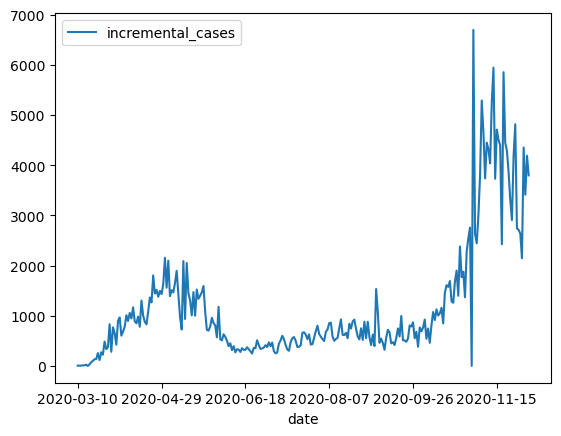

In [7]:
# get selected counties
chicago = df[df.entity == 'Illinois-Cook']
chicago = chicago[['date', 'incremental_cases']]
#miami.reset_index(inplace=True)
chicago.plot(x='date', y='incremental_cases')


In [8]:
diffDf = chicago.set_index('date')

#need to differentiate twice to not be stationary
statDF = diffDf.diff()
firstVal = diffDf.iloc[0,:].incremental_cases
split = int(0.85 * len(statDF))
train = statDF.iloc[:split,:]
test = statDF.iloc[split:, :]
compareTest = diffDf.iloc[split:, :]

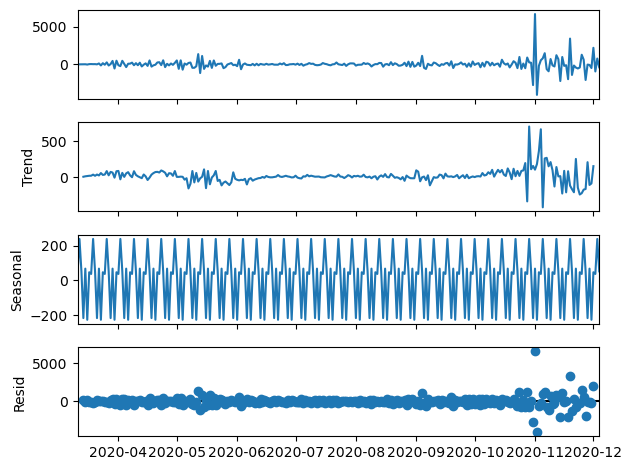

In [73]:
analysis = statDF.copy()
analysis.dropna(inplace=True)
analysis.index = pd.to_datetime(analysis.index)


decompose_result_mult = seasonal_decompose(analysis)

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

In [9]:
def fromTestDiffToActualInc(test, firstVal):
    test.iloc[0,0] += firstVal
    
    return test.cumsum()

In [10]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

train = train.loc[:, ['incremental_cases']].reset_index()
n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

p_values = [1,2,3]
q_values = [1,2,3]

P_values = [1,2,3]
Q_values = [1,2,3]


best_score, best_cfg = float("inf"), None

for p in p_values:
    for q in q_values:
        for P in P_values:
            for Q in Q_values:
                order = (p, q, P, Q)
                print(order)
                avg = 0
                for train_index, val_index in tscv.split(train):
                    train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
                    try:
                        model=sm.tsa.statespace.SARIMAX(train['incremental_cases'],order=(p,1,q), seasonal_order=(P,1,Q,7)).fit()
                    except:
                        continue
                    forecast = model.forecast(steps=val_data.shape[0])
                    mse = mean_squared_error(val_data.incremental_cases, forecast)
                    avg += mse
                if avg < best_score:
                    if avg > 0:
                        best_score, best_cfg = avg, order


print(f'Best ARIMA parameters: {best_cfg} with MSE: {best_score}')

(1, 1, 1, 1)
(1, 1, 1, 2)
(1, 1, 1, 3)
(1, 1, 2, 1)
(1, 1, 2, 2)
(1, 1, 2, 3)
(1, 1, 3, 1)
(1, 1, 3, 2)
(1, 1, 3, 3)
(1, 2, 1, 1)
(1, 2, 1, 2)
(1, 2, 1, 3)
(1, 2, 2, 1)
(1, 2, 2, 2)
(1, 2, 2, 3)
(1, 2, 3, 1)
(1, 2, 3, 2)
(1, 2, 3, 3)
(1, 3, 1, 1)
(1, 3, 1, 2)
(1, 3, 1, 3)
(1, 3, 2, 1)
(1, 3, 2, 2)
(1, 3, 2, 3)
(1, 3, 3, 1)
(1, 3, 3, 2)
(1, 3, 3, 3)
(2, 1, 1, 1)
(2, 1, 1, 2)
(2, 1, 1, 3)
(2, 1, 2, 1)
(2, 1, 2, 2)
(2, 1, 2, 3)
(2, 1, 3, 1)
(2, 1, 3, 2)
(2, 1, 3, 3)
(2, 2, 1, 1)
(2, 2, 1, 2)
(2, 2, 1, 3)
(2, 2, 2, 1)
(2, 2, 2, 2)
(2, 2, 2, 3)
(2, 2, 3, 1)
(2, 2, 3, 2)
(2, 2, 3, 3)
(2, 3, 1, 1)
(2, 3, 1, 2)
(2, 3, 1, 3)
(2, 3, 2, 1)
(2, 3, 2, 2)
(2, 3, 2, 3)
(2, 3, 3, 1)
(2, 3, 3, 2)
(2, 3, 3, 3)
(3, 1, 1, 1)
(3, 1, 1, 2)
(3, 1, 1, 3)
(3, 1, 2, 1)
(3, 1, 2, 2)
(3, 1, 2, 3)
(3, 1, 3, 1)
(3, 1, 3, 2)
(3, 1, 3, 3)
(3, 2, 1, 1)
(3, 2, 1, 2)
(3, 2, 1, 3)
(3, 2, 2, 1)
(3, 2, 2, 2)
(3, 2, 2, 3)
(3, 2, 3, 1)
(3, 2, 3, 2)
(3, 2, 3, 3)
(3, 3, 1, 1)
(3, 3, 1, 2)
(3, 3, 1, 3)
(3, 3, 2, 1)
(3, 3, 2, 2)

In [11]:

print(f'Best ARIMA parameters: {best_cfg} with MSE: {best_score}')

Best ARIMA parameters: (1, 3, 3, 3) with MSE: 261661.96491228067


In [12]:
model = sm.tsa.statespace.SARIMAX(train['incremental_cases'],order=(1,1,3), seasonal_order=(3,1,3,7)).fit()
                   
pred = model.forecast(steps=41)




-7.413246486106315


<Axes: title={'center': 'SARIMA Predictions for Chicago'}, xlabel='date'>

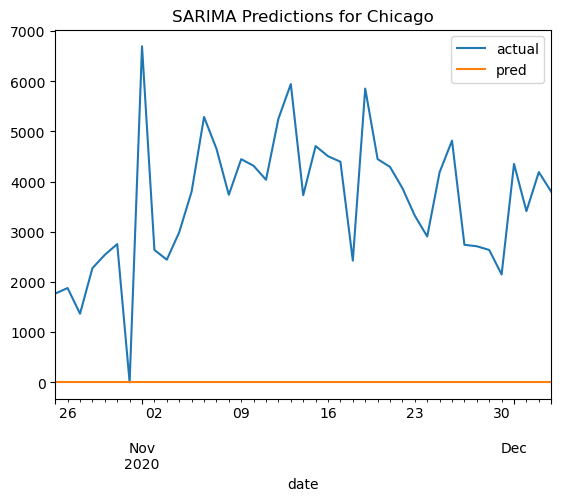

In [15]:
predictTest = pd.DataFrame(pred)
predictTest.columns=['incremental_cases']

foo = pd.DataFrame(model.fittedvalues, columns=['incremental_cases'])

foo.iloc[0,0] = diffDf.iloc[0,0]
foo = foo.cumsum()

firstVal = foo.iloc[-1,0].copy()

fooooo = predictTest.copy()
finalIncrementPreds = fromTestDiffToActualInc(fooooo, firstVal)



r2 = r2_score(chicago.iloc[split:, :].incremental_cases, finalIncrementPreds)
print(r2)

prediction = pd.DataFrame({'actual':chicago.iloc[split:, :].incremental_cases.reset_index(drop = True), 
              'pred':finalIncrementPreds.incremental_cases.reset_index(drop = True)})
prediction['date'] = pd.to_datetime(test.index)
prediction.plot(x = 'date', y = ['actual', 'pred'], title='SARIMA Predictions for Chicago')

-12.506265089244886


<Axes: xlabel='date'>

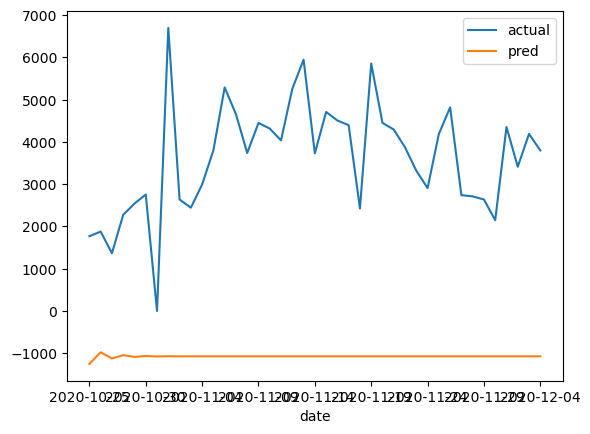

In [17]:
model = sm.tsa.statespace.SARIMAX(train['incremental_cases']).fit()
                   
pred = model.forecast(steps=41)




predictTest = pd.DataFrame(pred)
predictTest.columns=['incremental_cases']

foo = pd.DataFrame(model.fittedvalues, columns=['incremental_cases'])

foo.iloc[0,0] = diffDf.iloc[0,0]
foo = foo.cumsum()

firstVal = foo.iloc[-1,0].copy()

fooooo = predictTest.copy()
finalIncrementPreds = fromTestDiffToActualInc(fooooo, firstVal)



r2 = r2_score(chicago.iloc[split:, :].incremental_cases, finalIncrementPreds)
print(r2)

prediction = pd.DataFrame({'actual':chicago.iloc[split:, :].incremental_cases.reset_index(drop = True), 
              'pred':finalIncrementPreds.incremental_cases.reset_index(drop = True)})
prediction['date'] = test.index
prediction.plot(x = 'date', y = ['actual', 'pred'])

<Axes: >

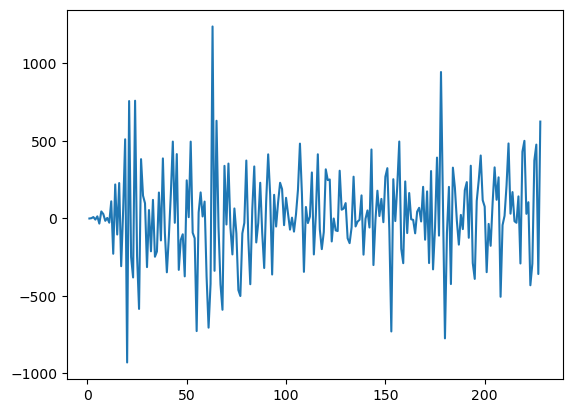

In [13]:
model.resid.plot()

<Axes: xlabel='date'>

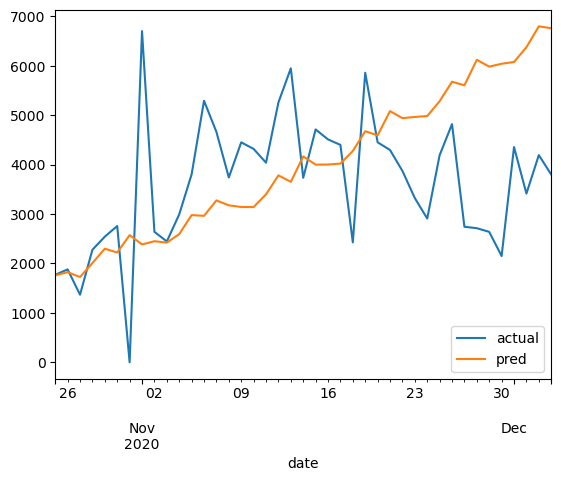

In [11]:
prediction = pd.DataFrame({'actual':chicago.iloc[split:, :].incremental_cases.reset_index(drop = True), 
              'pred':finalIncrementPreds.incremental_cases.reset_index(drop = True)})
prediction['date'] = test.index
prediction['date'] = pd.to_datetime(prediction['date'], format="%Y-%m-%d")
prediction.plot(x = 'date', y = ['actual', 'pred'])